In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
from scipy.linalg import dft

from src.data.load_dataset import generate_frequency_XOR, generate_frequency_detection

In [ ]:
# how to sample sine waves with certain frequency discreetly
duration = 0.2 # seconds
fs = 2000 # Hz
f1 = 30

In [ ]:
# t-steps
t = np.arange(0, duration, 1 / fs)
d = len(t)
assert d == fs * duration, "Dimensions of t-series is incorrect"

# dft matrix
dft_mat = dft(d, scale='sqrtn')

# what is the row of the dft matrix that I should sample??
idx = int(f1 * duration)
fig = plt.figure()
plt.plot(dft_mat[idx].real)
print(idx)

In [ ]:
import scipy
num_samples, sampling_rate, freq, duration, snr, seed = 5000, 2000, 20, 0.1, 0.8, None

In [ ]:
np.random.seed(seed)

N = int(sampling_rate * duration)
noise_amplitude = np.sqrt(1 - snr ** 2)

# dft matrix
A = scipy.linalg.dft(N, scale='sqrtn')
idx = int(freq * duration)

In [ ]:
# positive examples
n_pos = int(num_samples / 2)
c = np.zeros((N, n_pos), dtype='complex')
rand = np.random.normal(loc=0, scale=1, size=(n_pos, 2)).view(complex).flatten()
rand /= np.abs(rand)
c[idx] = rand
pos = np.sqrt(2 / (duration)) * snr * (A @ c).T.real

# norms
i = np.random.randint(100)
norms = la.norm(pos, axis=1) ** 2 * duration 
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(121)
plt.plot(pos[i])

ax = fig.add_subplot(122)
plt.title(np.mean(norms))
plt.plot(norms)
plt.ylim(0, 2)

In [ ]:
# noise for positive egs
rand = np.random.normal(loc=0, scale=1, size=(N, n_pos, 2)).view(complex).squeeze(axis=2)
rand /= np.abs(rand)
rand[idx] = 0. # don't add noise to the signal component
noise = np.sqrt(2 / (duration)) * noise_amplitude / np.sqrt(N - 1) * (A @ rand).T.real

# norms
i = np.random.randint(100)
norms = la.norm(noise, axis=1) ** 2 * duration 
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(121)
plt.plot(noise[i])

ax = fig.add_subplot(122)
plt.title(np.mean(norms))
plt.plot(norms)
plt.ylim(0, 2)

In [ ]:
# combine
X_pos = pos + noise

# norms
i = np.random.randint(100)
norms = la.norm(X_pos, axis=1) ** 2 * duration 
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(121)
plt.plot(X_pos[i])

ax = fig.add_subplot(122)
plt.title(np.mean(norms))
plt.plot(norms)
plt.ylim(0.5, 1.5)

In [ ]:
# negative egs
n_neg = int(num_samples / 2)
c = np.random.normal(loc=0, scale=1, size=(N, n_neg, 2)).view(complex).squeeze(axis=2)
c /= np.abs(c)
X_neg = np.sqrt(2 / (N * duration)) * (A @ c).T.real

# norms
i = np.random.randint(100)
norms = la.norm(X_neg, axis=1) ** 2 * duration 
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(121)
plt.plot(X_neg[i])

ax = fig.add_subplot(122)
plt.title(np.mean(norms))
plt.plot(norms)
plt.ylim(0.5, 1.5)

In [ ]:
import sklearn.utils as sk_utils
def generate_frequency_detection(num_samples, sampling_rate, freq, duration, snr, seed=None):
    """
    Generate frequency detection task. The positive examples are pure
    sinusoids with additive gaussian noise and the negative examples are 
    white noise. The examples are generated using the DFT matrix.

    Parameters
    ----------

    num_samples : int
        Number of total examples

    sampling_rate : int Hz
        Sampling rate of the signal
    
    freq : int Hz
        Frequency of the signal

    duration: float
        Length of the signal in seconds.

    snr : float, 0 <= a <= 1
        Determines the SNR of the signal.
        SNR = a ** 2 / (1 - a ** 2)

    seed : int
        Random state of the generated examples

    Returns
    -------
    X : (array-like) of shape (num_samples, num_features)
        Every row corresponds to an example with num_features components.
        num_features =  sampling_rate * duration

    y : (array-like) of shape (num_samples,)
        Target label (0/1) for every example. 
    """

    np.random.seed(seed)
    
    N = int(sampling_rate * duration)
    noise_amplitude = np.sqrt(1 - snr ** 2)

    # dft matrix
    A = scipy.linalg.dft(N, scale='sqrtn')
    idx = int(freq * duration) # row of DFT matrix that corresponds to the frequency

    # positive examples
    n_pos = int(num_samples / 2)
    c = np.zeros((N, n_pos), dtype='complex')
    rand = np.random.normal(loc=0, scale=1, size=(n_pos, 2)).view(complex).flatten()
    rand /= np.abs(rand)
    c[idx] = rand
    X_pos = np.sqrt(2 / duration) * snr * (A @ c).T.real

    # noise for positive egs
    rand = np.random.normal(loc=0, scale=1, size=(N, n_pos, 2)).view(complex).squeeze(axis=2)
    rand /= np.abs(rand)
    rand[idx] = 0. # don't add noise to the signal component
    noise = np.sqrt(2 / ((N-1) * duration)) * noise_amplitude * (A @ rand).T.real
    X_pos += noise

    # negative egs
    n_neg = int(num_samples / 2)
    c = np.random.normal(loc=0, scale=1, size=(N, n_neg, 2)).view(complex).squeeze(axis=2)
    c /= np.abs(c)
    X_neg = np.sqrt(2 / (N * duration)) * (A @ c).T.real

    # concatenate and shuffle
    X = np.vstack((X_pos, X_neg))
    y = np.hstack((np.ones(n_pos), np.zeros(n_neg)))
    X, y = sk_utils.shuffle(X, y)

    return X, y

In [ ]:
num_samples, sampling_rate, freq, duration, snr, seed = 5000, 4000, 10, 0.2, 0.8, None
X, y = generate_frequency_detection(num_samples, sampling_rate, freq, duration, snr, seed)
norms = la.norm(X, axis=1) ** 2 * duration

In [ ]:
fig = plt.figure(figsize=(12, 4))
i = np.random.randint(100)
ax = fig.add_subplot(121)
plt.plot(X[y==0][i], 'r')
plt.plot(X[y==1][i], 'b')

ax = fig.add_subplot(122)
t = np.arange(2500)
plt.plot(t, norms[y==0], 'r')
plt.plot(t + 2500, norms[y==1], 'b')
print(np.mean(norms[y==0]), np.mean(norms[y==1]))

In [ ]:
# now do the same for XOR
num_samples, sampling_rate, freq1, freq2, duration, snr, seed = 5000, 2000, 50, 80, 0.1, 0.8, None

In [ ]:
np.random.seed(seed)

N = int(sampling_rate * duration)
noise_amplitude = np.sqrt(1 - snr ** 2)

#dft matrix
A = scipy.linalg.dft(N, scale='sqrtn')
idx1 = int(freq1 * duration) # row of DFT matrix that corresponds to the frequency
idx2 = int(freq2 * duration)

In [ ]:
# positive examples
n_pos = int(num_samples/2)
c = np.zeros((N, n_pos), dtype='complex')
rand = np.random.normal(loc=0, scale=1, size=(int(n_pos/ 2), 2)).view(complex).flatten()
rand /= np.abs(rand)
c[idx1, :int(n_pos/2)] = rand

rand = np.random.normal(loc=0, scale=1, size=(int(n_pos/ 2), 2)).view(complex).flatten()
rand /= np.abs(rand)
c[idx2, int(n_pos/2):] = rand
pos = np.sqrt(2 / duration) * snr * (A @ c).T.real

norms = la.norm(pos, axis=1) ** 2 * duration
# norms
fig = plt.figure(figsize=(12, 4))
i = np.random.randint(100)
ax = fig.add_subplot(121)
plt.plot(pos[i], 'r')
plt.plot(pos[-i], 'b')

ax = fig.add_subplot(122)
t = np.arange(2500)
plt.plot(t, norms, 'r')
print(np.mean(norms[:1250]), np.mean(norms[1250:]))

In [ ]:
# noise for positive egs
rand = np.random.normal(loc=0, scale=1, size=(N, n_pos, 2)).view(complex).squeeze(axis=2)
rand /= np.abs(rand)
rand[idx1, :int(n_pos/2)] = 0. # don't add noise for signal frequency
rand[idx2, int(n_pos/2):] = 0.
noise = np.sqrt(2 / ((N-1) * duration)) * noise_amplitude * (A @ rand).T.real

norms = la.norm(noise, axis=1) ** 2 * duration
# norms
fig = plt.figure(figsize=(12, 4))
i = np.random.randint(100)
ax = fig.add_subplot(121)
plt.plot(noise[i], 'r')
plt.plot(noise[-i], 'b')

ax = fig.add_subplot(122)
t = np.arange(2500)
plt.plot(t, norms, 'r')
print(np.mean(norms[:1250]), np.mean(norms[1250:]))

In [ ]:
X_pos = pos + noise

norms = la.norm(X_pos, axis=1) ** 2 * duration
# norms
fig = plt.figure(figsize=(12, 4))
i = np.random.randint(100)
ax = fig.add_subplot(121)
plt.plot(X_pos[i], 'r')
plt.plot(X_pos[-i], 'b')

ax = fig.add_subplot(122)
t = np.arange(2500)
plt.plot(t, norms, 'r')
print(np.mean(norms[:1250]), np.mean(norms[1250:]))

In [ ]:
# negative egs
n_neg = int(num_samples/2)

# mixed egs
c = np.zeros((N, int(n_neg/2)), dtype='complex')
rand = np.random.normal(loc=0, scale=1, size=(1, int(n_neg/2), 2)).view(complex).squeeze(axis=2)
rand /= np.abs(rand)
c[[idx1, idx2]] = rand
mixed = np.sqrt(1 / duration) * snr * (A @ c).T.real

norms = la.norm(mixed, axis=1) ** 2 * duration
# norms
fig = plt.figure(figsize=(12, 4))
i = np.random.randint(100)
ax = fig.add_subplot(121)
plt.plot(mixed[i], 'r')

ax = fig.add_subplot(122)
t = np.arange(1250)
plt.plot(t, norms, 'r')
plt.title(np.mean(norms))
plt.ylim(0, 2)

In [ ]:
# noise for mixed egs
rand = np.random.normal(loc=0, scale=1, size=(N, int(n_neg/2), 2)).view(complex).squeeze(axis=2)
rand /= np.abs(rand)
rand[[idx1, idx2]]= 0.
noise = np.sqrt(2 / ((N-2) * duration) ) * noise_amplitude * (A @ rand).T.real

norms = la.norm(noise, axis=1) ** 2 * duration
# norms
fig = plt.figure(figsize=(12, 4))
i = np.random.randint(100)
ax = fig.add_subplot(121)
plt.plot(noise[i], 'r')

ax = fig.add_subplot(122)
t = np.arange(1250)
plt.plot(t, norms, 'r')
print(np.mean(norms))

In [ ]:
X_mixed = mixed + noise

norms = la.norm(X_mixed, axis=1) ** 2 * duration
# norms
fig = plt.figure(figsize=(12, 4))
i = np.random.randint(100)
ax = fig.add_subplot(121)
plt.plot(X_mixed[i], 'r')

ax = fig.add_subplot(122)
t = np.arange(1250)
plt.plot(t, norms, 'r')
print(np.mean(norms))

In [ ]:
# noise as negative egs
c = np.random.normal(loc=0, scale=1, size=(N, int(n_neg/2), 2)).view(complex).squeeze(axis=2)
c /= np.abs(c)
X_noise = np.sqrt(2 / (N * duration)) * (A @ c).T.real

norms = la.norm(X_noise, axis=1) ** 2 * duration
# norms
fig = plt.figure(figsize=(12, 4))
i = np.random.randint(100)
ax = fig.add_subplot(121)
plt.plot(X_noise[i], 'r')

ax = fig.add_subplot(122)
t = np.arange(1250)
plt.plot(t, norms, 'r')
print(np.mean(norms))

In [ ]:
num_samples, sampling_rate, freq1, freq2, duration, snr, seed = 5000, 2000, 50, 80, 0.1, 0.8, None
X, y = generate_frequency_XOR(num_samples, sampling_rate, freq1, freq2, duration, snr, seed, shuffle=False)
norms = la.norm(X, axis=1) ** 2 * duration

In [ ]:
fig = plt.figure(figsize=(12, 4))
i = np.random.randint(100)
ax = fig.add_subplot(121)
plt.plot(X[y==0][1251], 'r')
plt.plot(X[y==1][-i], 'b')

ax = fig.add_subplot(122)
t = np.arange(2500)
plt.plot(t, norms[y==0], 'r')
plt.plot(t + 2500, norms[y==1], 'b')
print(np.mean(norms[y==0]), np.mean(norms[y==1]))

1.0011066113484826 0.9996439012904622


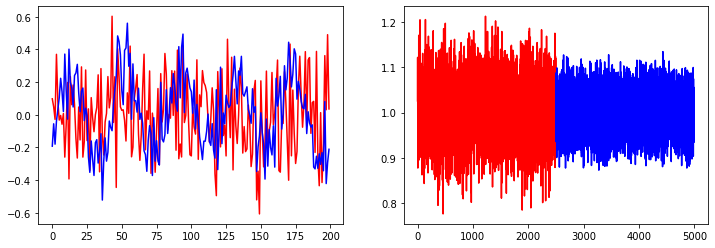

In [6]:
# check the src version now
num_samples, sampling_rate, freq, duration, snr, seed = 5000, 2000, 50, 0.1, 0.8, None
X, y = generate_frequency_detection(num_samples, sampling_rate, freq, duration, snr, seed)
norms = la.norm(X, axis=1) ** 2 * duration

fig = plt.figure(figsize=(12, 4))
i = np.random.randint(100)
ax = fig.add_subplot(121)
plt.plot(X[y==0][i], 'r')
plt.plot(X[y==1][i], 'b')

ax = fig.add_subplot(122)
t = np.arange(2500)
plt.plot(t, norms[y==0], 'r')
plt.plot(t + 2500, norms[y==1], 'b')
print(np.mean(norms[y==0]), np.mean(norms[y==1]))

1.0000937365042868 0.9998053600773955


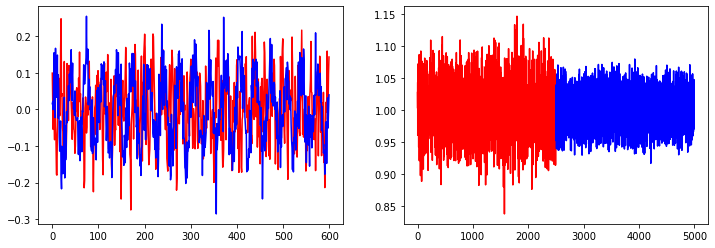

In [11]:
# check src version of XOR
num_samples, sampling_rate, freq1, freq2, duration, snr, seed = 5000, 3000, 30, 90, 0.2, 0.8, None
X, y = generate_frequency_XOR(num_samples, sampling_rate, freq1, freq2, duration, snr, seed, shuffle=False)
norms = la.norm(X, axis=1) ** 2 * duration

fig = plt.figure(figsize=(12, 4))
i = np.random.randint(100)
ax = fig.add_subplot(121)
plt.plot(X[y==0][i], 'r')
plt.plot(X[y==1][-i], 'b')

ax = fig.add_subplot(122)
t = np.arange(2500)
plt.plot(t, norms[y==0], 'r')
plt.plot(t + 2500, norms[y==1], 'b')
print(np.mean(norms[y==0]), np.mean(norms[y==1]))